<a href="https://colab.research.google.com/github/Sohaib-Khattak/Learn-Log/blob/main/UNSUPERVISED_LEARNING_METHODS_FOR_FUNCTIONAL_DATA_WITH_MISSING_OBSERVATIONS_especially_for_alzimer_disease_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ========================================
# Alzheimer's Disease Clustering Project
# ========================================

# --- Step 0: Import Libraries ---

In [ ]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
import random
from sklearn.impute import SimpleImputer

# Inline plots for Jupyter

In [ ]:

%matplotlib inline

# --- Step 1: Setup Directories ---

In [ ]:
data_dir = "/content/data"
out_dir = "results"
os.makedirs(out_dir, exist_ok=True)

 --- Step 2: Load Data ---

In [ ]:
fa = pd.read_csv(os.path.join(data_dir, "/content/sample_data/fa_curves.csv"))
bio = pd.read_csv(os.path.join(data_dir, "/content/sample_data/biomarkers.csv"))
cog = pd.read_csv(os.path.join(data_dir, "/content/sample_data/cognitive_scores.csv"))

print("✅ Data Loaded:")
print(f"FA shape: {fa.shape}, Biomarkers shape: {bio.shape}, Cognitive shape: {cog.shape}\n")

✅ Data Loaded:
FA shape: (100, 11), Biomarkers shape: (100, 6), Cognitive shape: (100, 11)



# --- Step 3: Merge Data ---

In [ ]:
merged = fa.merge(bio, on="patient_id").merge(cog, on="patient_id")
merged = merged.set_index("patient_id")
merged.head()

,FA_t0,FA_t1,FA_t2,FA_t3,FA_t4,FA_t5,FA_t6,FA_t7,FA_t8,FA_t9,...,score_t0,score_t1,score_t2,score_t3,score_t4,score_t5,score_t6,score_t7,score_t8,score_t9
patient_id,,,,,,,,,,,,,,,,,,,,,
P001,0.434074,0.422395,0.412255,0.419316,0.390559,0.394807,0.355237,0.353266,0.346866,0.307519,...,25.990868,26.018257,25.323289,25.671590,25.047737,25.049634,NaN,24.789818,24.150905,24.654289
P002,0.488841,0.481432,NaN,0.431963,0.413982,0.387778,0.358162,0.335389,0.336208,NaN,...,29.327976,29.309390,NaN,27.968940,28.207986,27.503631,27.327269,27.170433,26.674443,25.362911
P003,0.476994,0.460645,0.457306,0.453738,0.435784,0.432795,NaN,0.433596,0.415239,NaN,...,27.130894,26.609785,26.337782,26.622649,26.207698,26.496788,25.976347,25.417087,25.076086,25.650634
P004,0.594067,0.571224,0.537587,0.555862,NaN,0.511680,NaN,0.465756,0.436888,0.443704,...,27.508885,27.528632,27.420270,27.215754,26.503660,26.361685,25.648643,24.910602,24.980271,25.501639
P005,0.472244,0.469512,NaN,0.448006,0.445476,0.431984,0.406910,0.408560,0.412522,0.394057,...,26.656412,27.127135,25.804696,26.676132,26.266659,25.562072,25.555489,25.382000,24.879169,24.791843


# --- Step 4: Missing Data Imputation (EM Imputer) ---

In [ ]:
class EMImputer:
    """Expectation-Maximization imputer using Gaussian Mixture Model"""
    def __init__(self, n_components=3, max_iter=10, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.random_state = random_state
        self.gmm = None
        self.missing_mask_ = None

    def fit_transform(self, X):
        X = np.array(X, dtype=float)
        mask = np.isnan(X)
        self.missing_mask_ = mask.copy()

        # Initialize missing values with column means
        col_means = np.nanmean(X, axis=0)
        inds = np.where(np.isnan(X))
        X[inds] = np.take(col_means, inds[1])

        # EM iterations
        for i in range(self.max_iter):
            self.gmm = GaussianMixture(
                n_components=self.n_components,
                covariance_type="full",
                random_state=self.random_state
            )
            self.gmm.fit(X)
            X_imputed = self._conditional_expectation(X, mask)
            X[mask] = X_imputed[mask]
            print(f"EM iteration {i+1}/{self.max_iter} complete")

        self.imputed_ = X
        return X

    def _conditional_expectation(self, X, mask):
        probs = self.gmm.predict_proba(X)
        exp_values = np.zeros_like(X)
        for k in range(self.gmm.n_components):
            exp_values += probs[:, [k]] * self.gmm.means_[k]
        X_new = X.copy()
        X_new[mask] = exp_values[mask]
        return X_new

# Run EM imputer
print("Running EM imputation...")
em_imputer = EMImputer(n_components=3, max_iter=10)
X = em_imputer.fit_transform(merged.values)
mask = em_imputer.missing_mask_
print("✅ EM Imputation done.\n")


Running EM imputation...
EM iteration 1/10 complete
EM iteration 2/10 complete
EM iteration 3/10 complete
EM iteration 4/10 complete
EM iteration 5/10 complete
EM iteration 6/10 complete
EM iteration 7/10 complete
EM iteration 8/10 complete
EM iteration 9/10 complete
EM iteration 10/10 complete
✅ EM Imputation done.



# --- Step 5: Visualize FA Imputation ---

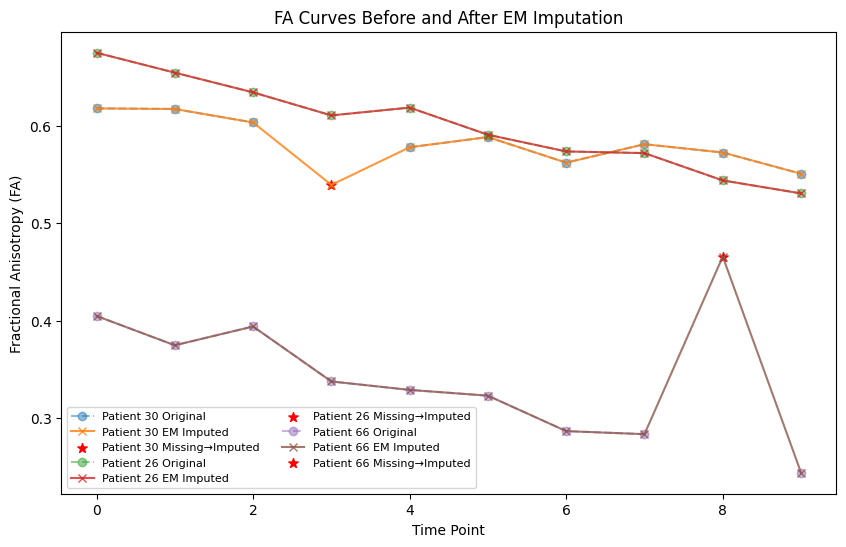

In [ ]:
fa_cols = [c for c in merged.columns if c.startswith("FA_t")]
fa_indices = [merged.columns.get_loc(c) for c in fa_cols]
patients_to_plot = random.sample(range(merged.shape[0]), 3)

plt.figure(figsize=(10,6))
for idx in patients_to_plot:
    original = merged.iloc[idx, fa_indices].values
    imputed = X[idx, fa_indices]
    missing_mask = mask[idx, fa_indices]
    plt.plot(original, "o--", alpha=0.5, label=f"Patient {idx+1} Original")
    plt.plot(imputed, "x-", alpha=0.8, label=f"Patient {idx+1} EM Imputed")
    plt.scatter(np.where(missing_mask)[0], imputed[missing_mask],
                c="red", s=50, marker="*", label=f"Patient {idx+1} Missing→Imputed")
plt.title("FA Curves Before and After EM Imputation")
plt.xlabel("Time Point")
plt.ylabel("Fractional Anisotropy (FA)")
plt.legend(fontsize=8, ncol=2)
plt.show()

# --- Step 6: Standardize Data ---


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- Step 7: PCA ---

Explained variance by first 5 components: 0.86


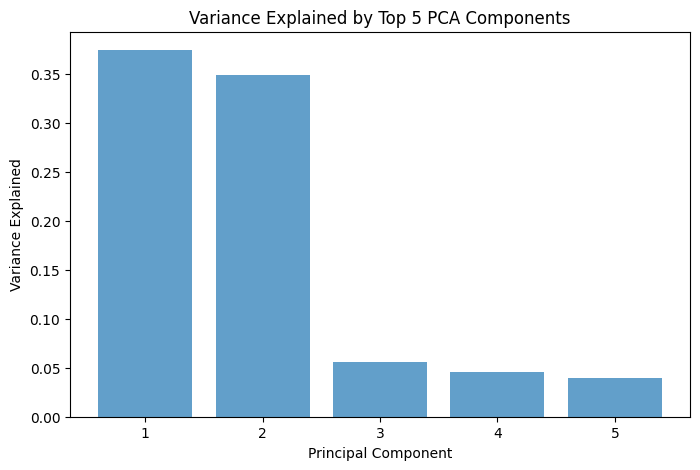

In [ ]:
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_var = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance by first 5 components: {explained_var:.2f}")

plt.figure(figsize=(8,5))
plt.bar(range(1,6), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Top 5 PCA Components")
plt.show()

# --- Step 8: GMM Clustering ---

Initialization 0
  Iteration 10
Initialization converged.


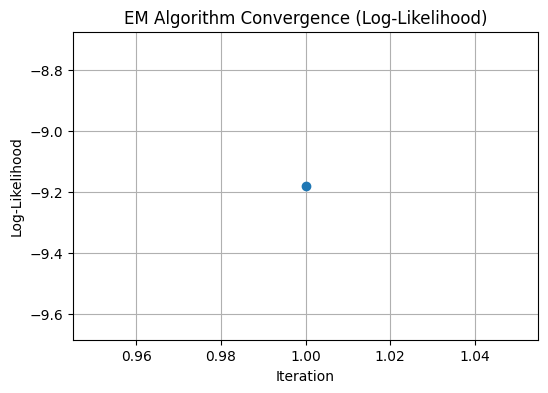

In [ ]:
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42, verbose=1, max_iter=100)
labels = gmm.fit_predict(X_pca)
merged["cluster"] = labels

# EM convergence plot
if hasattr(gmm, 'lower_bound_'):
    plt.figure(figsize=(6,4))
    lower_bounds_for_plot = np.atleast_1d(gmm.lower_bound_)
    plt.plot(range(1, len(lower_bounds_for_plot)+1), lower_bounds_for_plot, marker='o')
    plt.title("EM Algorithm Convergence (Log-Likelihood)")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.grid(True)
    plt.show()


# --- Step 9: GMM Cluster Visualization ---

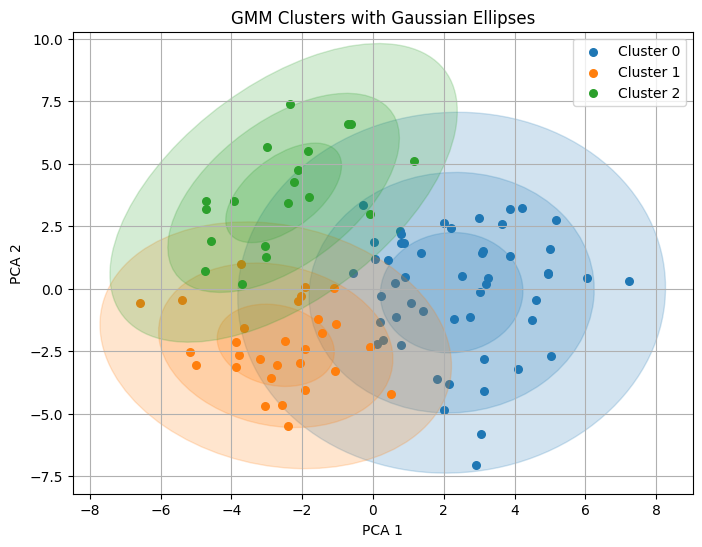

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2 * np.sqrt(s)
        for nsig in range(1,4):
            ax.add_patch(Ellipse(xy=(position[0],position[1]), width=nsig*width,
                                 height=nsig*height, angle=angle, alpha=0.2, **kwargs))

plt.figure(figsize=(8,6))
ax = plt.gca()
colors = ['#1f77b4','#ff7f0e','#2ca02c']
for i, color in enumerate(colors[:n_clusters]):
    data = X_pca[labels==i]
    plt.scatter(data[:,0], data[:,1], s=30, color=color, label=f'Cluster {i}')
    draw_ellipse(gmm.means_[i,:2], gmm.covariances_[i][:2,:2], ax=ax, color=color)
plt.title("GMM Clusters with Gaussian Ellipses")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()



# --- Step 10: Cluster Evaluation ---

In [ ]:
sil = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {sil:.3f}")

Silhouette Score: 0.291


# Task
The final task is to summarize Colab's GitHub integration features, including how to save a notebook to GitHub (as a new file or an update) and how to open a notebook from GitHub (from a repository or a Gist).

## Saving a Notebook to GitHub

### Subtask:
Explain how to save your current Colab notebook as a new file or an update to an existing file directly to your GitHub repository or a Gist using the 'File' menu.


## Saving a Notebook to GitHub

### Subtask:
Explain how to save your current Colab notebook as a new file or an update to an existing file directly to your GitHub repository or a Gist using the 'File' menu.

#### Instructions
1. To save the current notebook to GitHub, click on 'File' in the Colab menu bar.
2. From the dropdown, select 'Save a copy to GitHub'.
3. In the dialog that appears, you will have options to:    
a. Choose a GitHub repository you have access to.    
b. Specify the file name and path within that repository.    
c. Select whether to save it as a new file or overwrite an existing one (if the file path matches an existing one).    
d. Alternatively, choose to save it as a GitHub Gist if you want to share a quick snippet or a single notebook without committing it to a full repository.
4. After making your selections, click the 'OK' or 'Save' button to complete the process.

## Opening a Notebook from GitHub

### Subtask:
Explain how to open a notebook that is already stored in a GitHub repository or a Gist directly within Google Colab using the 'File' menu.


### Subtask
Explain how to open a notebook that is already stored in a GitHub repository or a Gist directly within Google Colab using the 'File' menu.

#### Instructions
1. To open a notebook from GitHub, click on 'File' in the Colab menu bar.
2. From the dropdown, select 'Open notebook'.
3. In the 'Open notebook' dialog, switch to the 'GitHub' tab.
4. You will have options to:
    a. Search for a specific GitHub repository by entering the repository URL or username/organization and repository name.
    b. Browse through your own repositories (if you've connected your GitHub account).
    c. If opening a Gist, select the 'Gist' option and provide the Gist ID or URL.
5. Once you've located the desired notebook file, select it and click 'Open' to load it into Colab.

## Final Task

### Subtask:
Provide a summary of Colab's GitHub integration features.


## Summary:

### Data Analysis Key Findings

*   **Saving to GitHub**: Colab allows users to save the current notebook directly to a GitHub repository or as a Gist. This functionality is accessible via the 'File' menu, selecting 'Save a copy to GitHub'. Users can choose a specific repository, define the file path and name, and either create a new file or update an existing one. Saving as a Gist is also an option for sharing quick snippets.
*   **Opening from GitHub**: Notebooks stored in GitHub repositories or Gists can be opened directly within Colab. This feature is found under the 'File' menu, by selecting 'Open notebook' and then navigating to the 'GitHub' tab. Users can search for repositories by URL or name, browse their own repositories, or open a Gist using its ID or URL.

### Insights or Next Steps

*   Colab's native GitHub integration simplifies version control and collaboration for Python notebooks, directly from the user interface, eliminating the need for external Git clients for basic operations.
*   Further integration could include options for committing with a custom message directly from Colab's save dialog, or enabling direct pull requests for more advanced collaborative workflows.
